# EEG Data Analysis

This Jupyter Notebook analyzes EEG data from a study on alcoholism. The data contains measurements from 64 electrodes sampled at 256 Hz for 1 second.

Click here to access the dataset: [Kaggle Dataset](https://www.kaggle.com/datasets/nnair25/Alcoholics)

## Data Description

The dataset contains the following information:

- 64 electrodes placed on subjects' scalps
- Sampling rate: 256 Hz
- Epoch duration: 3.9 milliseconds
- Two groups of subjects: alcoholic and control
- Stimuli: Single stimulus (S1) or two stimuli (S1 and S2)
- Stimulus types: Matched and non-matched



In [ ]:
# Import the necessary libraries

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, shapiro, ttest_ind
import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Data Loading and Unification Function

To streamline the process of working with multiple CSV files, a custom Python function named `df_unifier` has been created. This function simplifies the task of loading data from CSV files located in specific directories and combining them into a single Pandas DataFrame.

In [ ]:
# Set the directory path where your CSV files are located
fs_train_path = '/content/drive/MyDrive/Colab Notebooks/Project_NEURO/EEG_Alcohol/SMNI_CMI_TRAIN/'

fs_test_path = '/content/drive/MyDrive/Colab Notebooks/Project_NEURO/EEG_Alcohol/SMNI_CMI_TEST/'

def df_unifier(first_dir):

  # Initialize an empty list to store DataFrames
  all_dataframes = []


  # Loop through files in the 1st directory
  for filename in os.listdir(first_dir):
      if filename.endswith(".csv"):
          file_path = os.path.join(first_dir, filename)
          # Read each CSV file into a DataFrame
          df = pd.read_csv(file_path)
          all_dataframes.append(df)


  # Concatenate all DataFrames into one
  combined_df = pd.concat(all_dataframes, ignore_index=True)

  return combined_df


train_df = df_unifier(fs_train_path)



test_df = df_unifier(fs_test_path)


# Drop column Channel because we have sensor position.
# Drop column unnamed because we don't have specific data about this feature

train_df = train_df.drop('channel', axis=1)
train_df = train_df.drop('Unnamed: 0', axis=1)
train_df = train_df.drop('time', axis=1)
test_df = test_df.drop('channel', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('time', axis=1)
#look a the data
train_df.head(10)


,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,name
0,13,FP1,0,3.947,a,"S2 nomatch,",co2a0000369
1,13,FP1,1,4.924,a,"S2 nomatch,",co2a0000369
2,13,FP1,2,4.924,a,"S2 nomatch,",co2a0000369
3,13,FP1,3,4.435,a,"S2 nomatch,",co2a0000369
4,13,FP1,4,3.947,a,"S2 nomatch,",co2a0000369
5,13,FP1,5,3.459,a,"S2 nomatch,",co2a0000369
6,13,FP1,6,2.970,a,"S2 nomatch,",co2a0000369
7,13,FP1,7,1.994,a,"S2 nomatch,",co2a0000369
8,13,FP1,8,1.017,a,"S2 nomatch,",co2a0000369
9,13,FP1,9,-0.448,a,"S2 nomatch,",co2a0000369


## Visualize Filtered EEG Sensor Data

The `graph_wave` function facilitates the visualization of EEG sensor data with a focus on specific conditions, subjects, and trials. This function takes an input DataFrame and filters it based on multiple criteria to extract relevant data for visualization.

### Parameters:
- `df`: The input DataFrame containing EEG sensor data.
  
### Filtering Conditions:
The function applies the following filtering conditions to narrow down the data:
- `matching condition`: Filters for rows on 'matching condition'. It could be S1 obj, S2 match or S2 nomatch.
- `name`: Filters for rows with specific 'name'. Each name is a subject.
- `subject identifier`: Filters for rows with 'subject identifier'. It could be 'a' or 'c'
- `trial number`: Filters for rows with specific 'trial number'.

### Visualization Process:

1. **Data Filtering:**
   - The function applies the specified filtering conditions to the input DataFrame, selecting rows that meet all the criteria.

2. **Unique Sensor Positions:**
   - Extracts all unique sensor positions from the filtered data.

3. **Subplot Grid Creation:**
   - Calculates the number of rows and columns needed for the subplot grid based on the unique sensor positions.
   - Each subplot represents a unique sensor position.

4. **Plotting Data:**
   - Iterates through the unique sensor positions, creating separate subplots for each position.
   - Filters data for the current sensor position and resets the index.
   - Selects a subset of rows (0 - 255) for visualization.
   - Plots the sensor values against the sample numbers.

5. **Layout Adjustment:**
   - Hides any extra subplots if there are unused ones, ensuring a clean layout.

6. **Display:**
   - Adjusts the layout and displays the plotted sensor data, allowing for a clear visualization of EEG sensor values for specific conditions and positions.

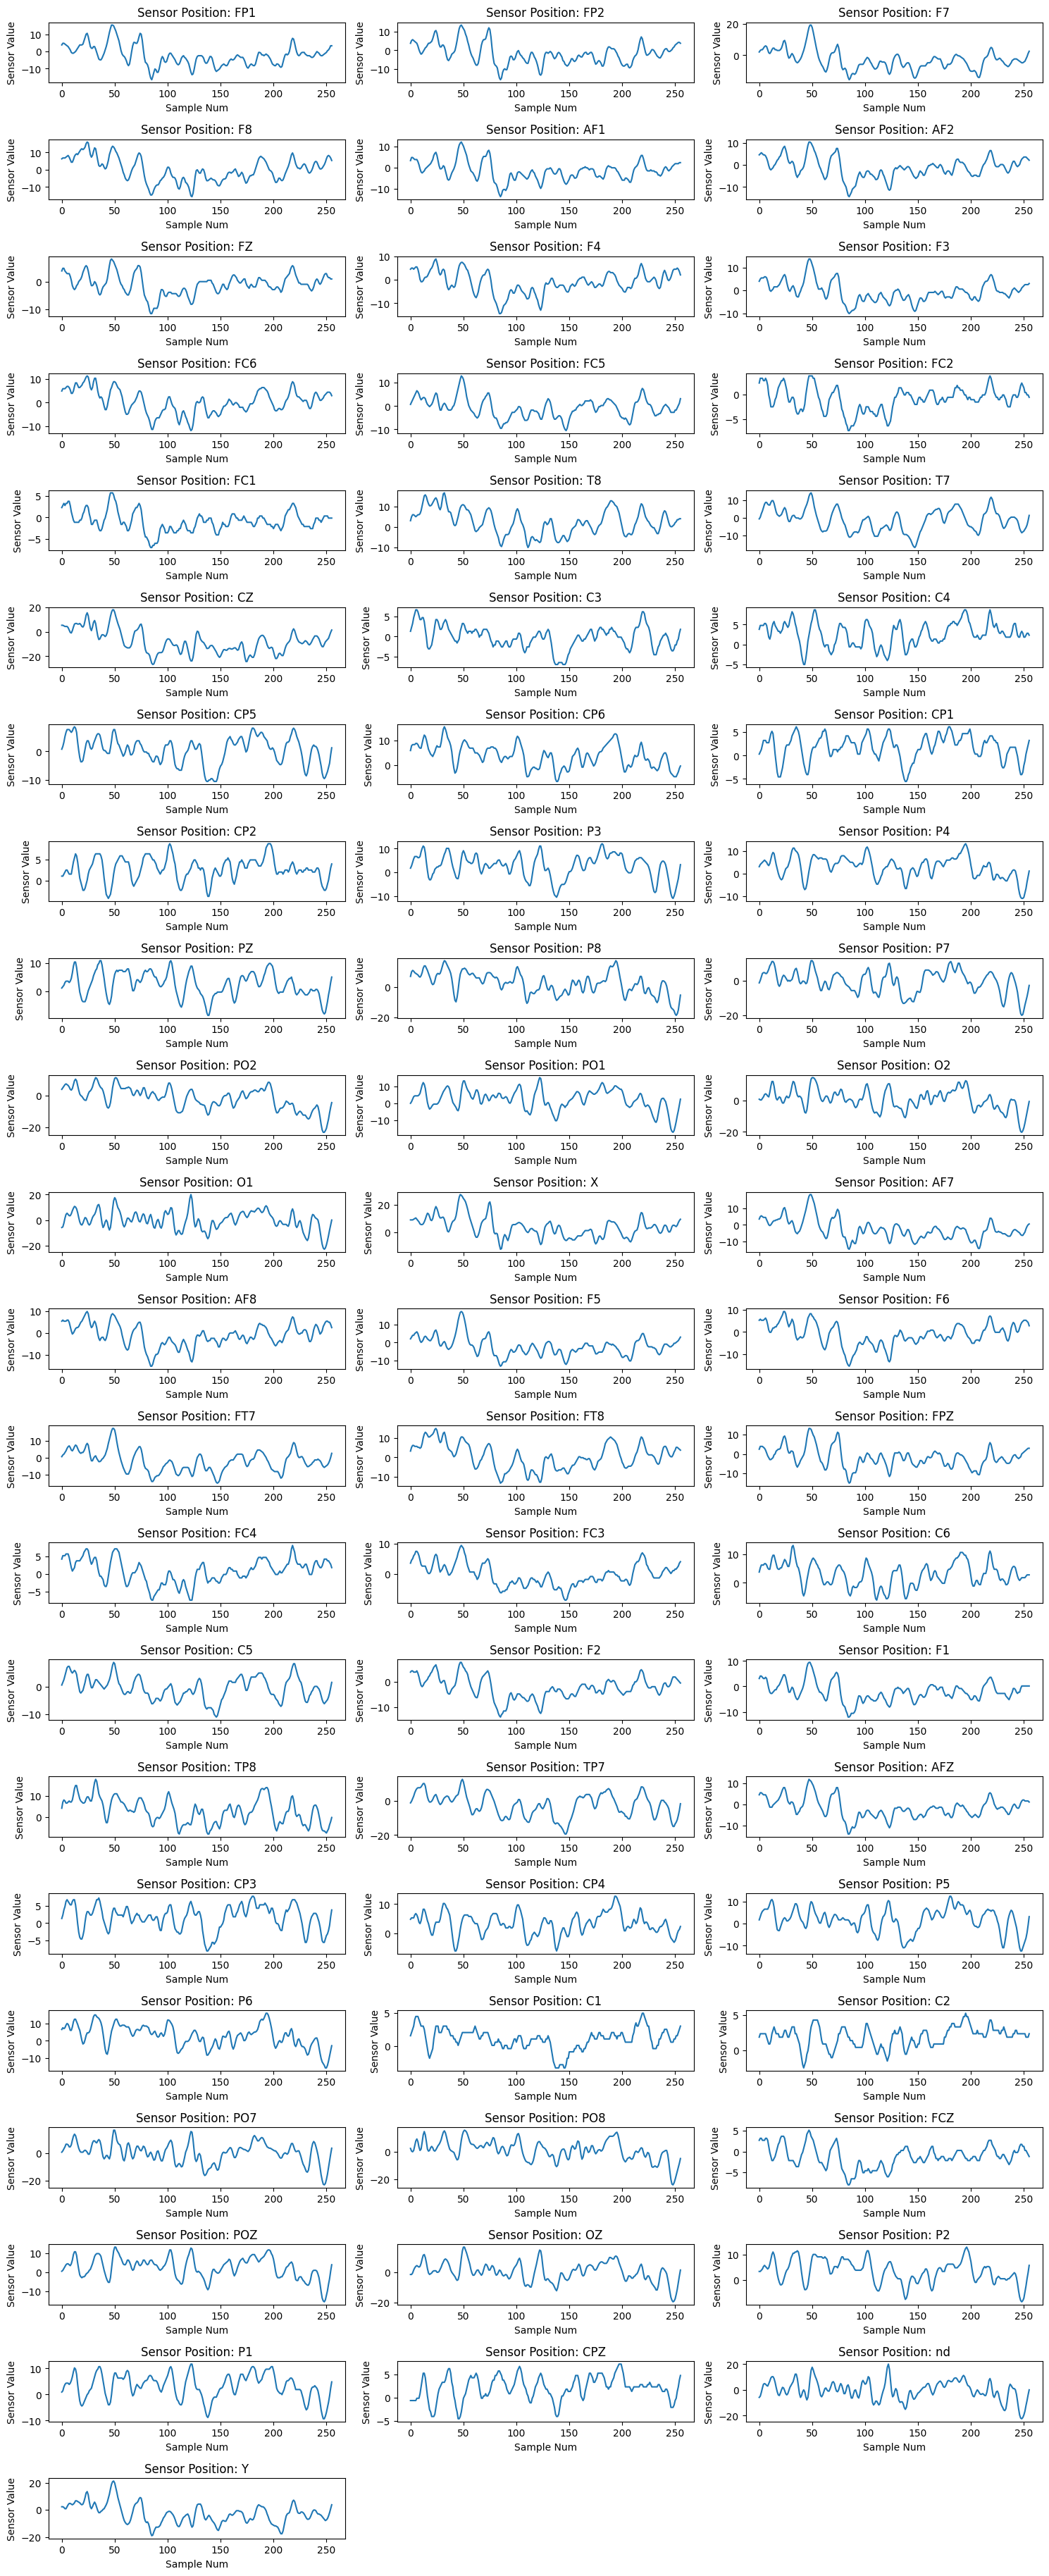

In [ ]:
def graph_wave(df):
    train_df = df.copy()

    # Additional filtering conditions
    condition2 = train_df['matching condition'] == 'S2 nomatch,'
    condition3 = train_df['name'] == 'co2a0000369'
    condition4 = train_df['subject identifier'] == 'a'
    condition5 = train_df['trial number'] == 13

    # Apply additional filtering conditions
    train_df = train_df[condition2 & condition3 & condition4 & condition5]


    # Extract all unique sensor positions from the 'sensor position' column
    unique_sensor_positions = train_df['sensor position'].unique()

    # Calculate the number of rows and columns for the subplot grid
    num_sensor_positions = len(unique_sensor_positions)
    num_columns = 3
    num_rows = -(-num_sensor_positions // num_columns)  # Ceiling division

    # Calculate the height of each subplot (1/3 of the total height)
    subplot_height = 5 * (1/3)

    # Create subplots with 3 columns and 1/3 of the height for each subplot
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, subplot_height * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through unique sensor positions and plot data in subplots
    for i, sensor_position in enumerate(unique_sensor_positions):
        # Filter data for the current sensor position
        filtered_train_df = train_df[train_df['sensor position'] == sensor_position]

        # Reset index and select rows 0 - 255
        filtered_train_df = filtered_train_df.reset_index(drop=True).iloc[0:256]

        # Plot data using sns.lineplot
        sns.lineplot(data=filtered_train_df, x='sample num', y='sensor value', ax=axes[i])
        axes[i].set_title(f'Sensor Position: {sensor_position}')
        axes[i].set_xlabel('Sample Num')
        axes[i].set_ylabel('Sensor Value')

    # Hide extra subplots if there are unused ones
    for j in range(i+1, num_rows * num_columns):
        fig.delaxes(axes[j])

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function to plot data for each unique sensor position
graph_wave(train_df)

##  Rank Significant Differences in Sensor Data


### Clinical Significance
This function identifies brain regions with the most significant differences in firing patterns. By conducting Mann-Whitney U tests and listing sensors below a threshold (p-value 0.05), the function reveals which sensors exhibit the most pronounced differences in activity between subjects labeled 'a' and 'c' when exposed to specific stimuli ('S1 obj', 'S2 match', 'S2 nomatch').

### Parameters
- `df1`: The input DataFrame containing EEG sensor data.
- `p_value_threshold` (optional, default: 0.05): The threshold for determining significance in Mann-Whitney U tests.

### Function Description

1. **Filter Data by Matching Condition and Group:**
   - Iterates through specified matching conditions ('S1 obj', 'S2 match', 'S2 nomatch').
   - Filters the input DataFrame based on the matching condition.
   - Separates data for alcoholic ('a') and control ('c') groups.

2. **Perform Mann-Whitney U Tests:**
   - Conducts Mann-Whitney U tests for each unique sensor position within the filtered data.
   - Compares sensor values between alcoholic and control groups.
   - Calculates Mann-Whitney U statistic and corresponding p-value.

3. **Rank and Display Results:**
   - Sorts results by p-value in descending order to identify sensor positions with significant differences.
   - Separates sensor positions below the specified p-value threshold (0.05).

4. **Visualize Results:**
   - Creates a grid of subplots, one for each matching condition.
   - Plots sensor positions on the x-axis and corresponding p-values on the y-axis using bar plots.
   - Displays only sensors below the specified p-value threshold (0.05).

### Return
- `results_sorted`: A DataFrame containing sorted results by p-value, indicating sensor positions with the most significant differences between alcoholic and control groups under various matching conditions.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


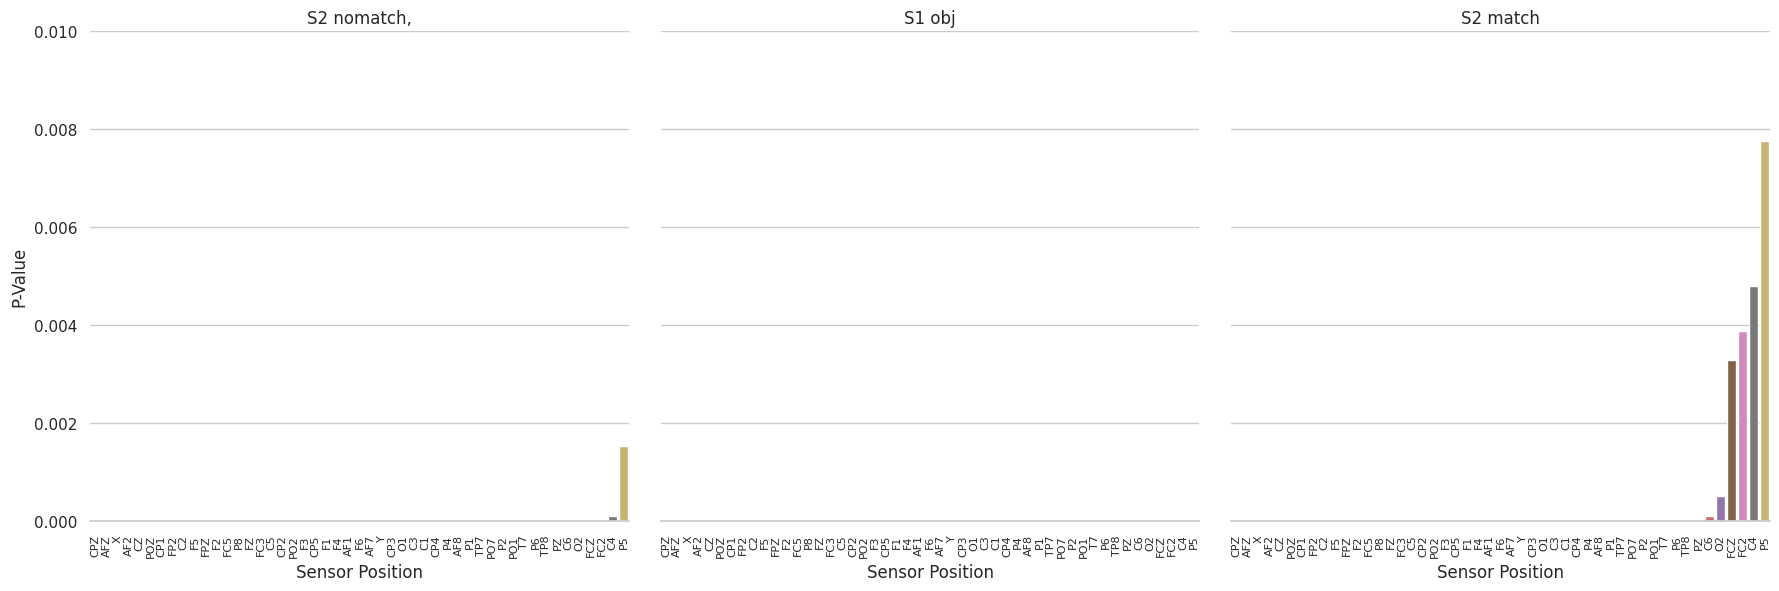

In [ ]:
def rank_diff_sensors_(df1, p_value_threshold=0.05):


    results = []

    # Iterate over matching conditions
    for mc in ['S1 obj', 'S2 match', 'S2 nomatch,']:
        df = df1[df1['matching condition'] == mc]
        sensor_position_col = 'sensor position'
        sensor_value_col = 'sensor value'
        subject_identifier_col = 'subject identifier'

        # Separate data for alcoholic and control groups
        alcoholic_df = df[df[subject_identifier_col] == 'a']
        control_df = df[df[subject_identifier_col] == 'c']

        # Iterate over unique sensor positions within the matching condition
        for sensor_position in df[sensor_position_col].unique():
            # Extract sensor values for alcoholic and control groups
            alcoholic_data = alcoholic_df[alcoholic_df[sensor_position_col] == sensor_position][sensor_value_col]
            control_data = control_df[control_df[sensor_position_col] == sensor_position][sensor_value_col]

            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(alcoholic_data, control_data)

            # Check if the p-value is below the threshold
            if p_value < p_value_threshold:
                # Store results in a dictionary
                results.append({'Matching Condition': mc, 'Sensor_Position': sensor_position, 'MannWhitneyU': statistic, 'P-Value': p_value})

    # Create a DataFrame from the list of significant results and sort by p-value
    results_df = pd.DataFrame(results)
    results_sorted = results_df.sort_values(by='P-Value')

    # Set plotting style
    sns.set(style="whitegrid")

    # Create a facet grid for visualization
    g = sns.FacetGrid(results_sorted, col="Matching Condition", col_wrap=3, height=6)
    g.map(sns.barplot, "Sensor_Position", "P-Value", palette="muted", ci=None)
    g.set_axis_labels("Sensor Position", "P-Value")
    g.set_titles(col_template="{col_name}")
    g.set_xticklabels(rotation=90, fontsize=8)
    g.despine(left=True)

    # Set custom y-axis limit to improve visibility of bars
    plt.ylim(0, 0.01)  # Adjust the y-axis limit as needed

    # Display the plot
    plt.show()

    # Return the sorted results for further analysis if needed
    return results_sorted


results = rank_diff_sensors_(train_df, p_value_threshold=0.05)



## Correlation per Sensor Pair for Matching Condition

### Clinical use
This function aims to identify brain regions that exhibit correlated activity during the presentation of individual stimuli (objects shown). By analyzing EEG sensor data under different matching conditions ('S1 obj', 'S2 match', 'S2 nomatch'), it discerns which regions in the brain fired together, indicating correlated responses to specific stimuli.

### Parameters
- `df1`: The input DataFrame containing EEG sensor data.
- `MA`: An integer (0, 1, or 2) representing the matching condition ('S1 obj', 'S2 match', 'S2 nomatch').
- `correlation_threshold` (optional, default: 0.97): The threshold for considering correlations as significant.

### Function Description

1. **Filter Data by Matching Condition:**
   - Filters the input DataFrame by the specified matching condition ('S1 obj', 'S2 match', 'S2 nomatch').

2. **Calculate Correlations and Sensor Pairs:**
   - For each unique subject identifier ('a' and 'c'), calculates correlations between sensor positions.
   - Creates a pivot table and generates combinations of sensor pairs.
   - Calculates correlations between sensor pairs and filters them based on the correlation threshold.
   - Stores significant correlations and corresponding sensor pairs for both 'a' and 'c' identifiers.

3. **Data Structuring and Handling:**
   - Ensures that the lists of correlations and sensor pairs have the same length.
   - Fills any missing values with NaN.
   - Creates a DataFrame containing correlations and sensor pairs for both 'a' and 'c' identifiers.

### Return
- `result_df`: A DataFrame containing significant correlations ('Correlation a' and 'Correlation c') and corresponding sensor pairs ('Sensor Pair a' and 'Sensor Pair c') for the specified matching condition.

In [ ]:
def calculate_corr_MANN(df1, MA, correlation_threshold=0.97):

    matching = MA
    mc = ['S1 obj', 'S2 match',  'S2 nomatch,'][matching]

    # Filter the DataFrame by matching condition
    df1 = df1[df1['matching condition'] == mc]

    # Get unique identifiers in the dataset
    identifiers = df1['subject identifier'].unique()

    # Initialize empty lists to store results
    correlations_a = []
    sensor_pairs_a = []
    correlations_c = []
    sensor_pairs_c = []

    # Loop through identifiers ('a' and 'c')
    for identifier in identifiers:
        # Filter the DataFrame by identifier
        df = df1[df1['subject identifier'] == identifier]

        # Calculate correlations and sensor pairs
        pivot_t = pd.pivot_table(df, values='sensor value', index='sample num', columns='sensor position').corr()
        columns_pt = list(pivot_t.columns)

        combinations_list = []
        for i in range(len(columns_pt)):
            for j in range(i + 1, len(columns_pt)):
                combo = [columns_pt[i], columns_pt[j]]
                if combo[0] != combo[1]:
                    combinations_list.append(combo)

        data = []
        for combo in combinations_list:
            value = pivot_t.loc[combo[0], combo[1]]
            data.append({'Sensor Pair a': f"{combo[0]} - {combo[1]}", 'Correlation a': value} if identifier == 'a'
                        else {'Sensor Pair c': f"{combo[0]} - {combo[1]}", 'Correlation c': value})

        result_df = pd.DataFrame(data)
        result_df = result_df[abs(result_df.iloc[:, 1]) >= correlation_threshold]  # Filter by correlation threshold

        # Store sensor pairs and correlations based on identifier ('a' or 'c')
        if identifier == 'a':
            correlations_a.extend(result_df['Correlation a'].tolist())
            sensor_pairs_a.extend(result_df['Sensor Pair a'].tolist())
        else:
            correlations_c.extend(result_df['Correlation c'].tolist())
            sensor_pairs_c.extend(result_df['Sensor Pair c'].tolist())

    # Ensure the lists have the same length by filling with NaN if necessary
    max_length = max(len(correlations_a), len(correlations_c))
    correlations_a += [np.nan] * (max_length - len(correlations_a))
    correlations_c += [np.nan] * (max_length - len(correlations_c))
    sensor_pairs_a += [np.nan] * (max_length - len(sensor_pairs_a))
    sensor_pairs_c += [np.nan] * (max_length - len(sensor_pairs_c))

    # Create a DataFrame from the lists of results
    result_df = pd.DataFrame({'Correlation a': correlations_a, 'Sensor Pair a': sensor_pairs_a,
                              'Correlation c': correlations_c, 'Sensor Pair c': sensor_pairs_c})

    return result_df

# Example usage
result_df = calculate_corr_MANN(train_df, 0,  correlation_threshold=0.97)
result_df.head(10)

,Correlation a,Sensor Pair a,Correlation c,Sensor Pair c
0,0.981458,AF1 - AF2,0.983587,AF1 - AF2
1,0.978679,AF7 - FPZ,0.994798,AF1 - AFZ
2,0.974545,AFZ - FP2,0.988050,AF2 - AFZ
3,0.975523,AFZ - FPZ,0.981220,AF8 - FP2
4,0.974684,CP1 - CPZ,0.974922,C5 - TP7
5,0.976873,CP3 - P3,0.981322,CP1 - CP3
6,0.976090,CP4 - P4,0.975497,CP1 - CPZ
7,0.972299,F1 - F2,0.970681,CP1 - P1
8,0.975037,F1 - F3,0.982797,CP2 - CP4
9,0.974093,FC1 - FCZ,0.972688,CP3 - P1


In [ ]:
result_df = calculate_corr_MANN(train_df, 1,  correlation_threshold=0.97)
result_df.head(10)

,Correlation a,Sensor Pair a,Correlation c,Sensor Pair c
0,0.977771,AF1 - AF2,0.992315,AF1 - AF2
1,0.989349,AF1 - AFZ,0.998199,AF1 - AFZ
2,0.995289,AF2 - AFZ,0.982722,AF1 - F1
3,0.976335,AF2 - FPZ,0.985773,AF1 - F2
4,0.973961,AF7 - AF8,0.971451,AF1 - F3
5,0.984871,AF7 - FP2,0.971461,AF1 - F4
6,0.983638,AF7 - FPZ,0.985255,AF1 - FZ
7,0.981221,AF7 - X,0.978973,AF2 - AF7
8,0.975226,AF8 - FP2,0.997134,AF2 - AFZ
9,0.973822,AFZ - FPZ,0.988503,AF2 - F2


In [ ]:
result_df = calculate_corr_MANN(train_df, 2,  correlation_threshold=0.97)
result_df.head(10)

,Correlation a,Sensor Pair a,Correlation c,Sensor Pair c
0,0.988165,AF1 - AF2,0.996049,AF1 - AF2
1,0.978617,AF1 - AFZ,0.995219,AF1 - AFZ
2,0.991263,AF2 - AFZ,0.997077,AF2 - AFZ
3,0.975000,C5 - T7,0.975839,AF2 - F4
4,0.971283,C5 - TP7,0.974718,AF7 - AF8
5,0.980791,CP3 - P3,0.985787,AF7 - FP1
6,0.973216,CP3 - P5,0.981715,AF7 - FP2
7,0.976109,CP4 - P4,0.985517,AF7 - FPZ
8,0.970748,CPZ - PZ,0.988358,AF8 - FP1
9,0.979784,F1 - F3,0.991166,AF8 - FP2


## Top N Correlations Visualization

### Clinical use
This function is designed to visualize the top N correlations between pairs of EEG sensors for a specific subject identifier ('a' or 'c'). By examining sensor data, it identifies the strongest positive and negative correlations, providing insights into the interrelated activity of different brain regions. This visualization aids in understanding the patterns of neural connectivity within the brain for the chosen subject group.

### Parameters
- `df1`: The input DataFrame containing EEG sensor data.
- `identifier` (optional, default: 'a'): The subject identifier ('a' or 'c') for whom correlations are calculated and visualized.
- `n` (optional, default: 20): The number of top positive and negative correlations to display.

### Function Description

1. **Filter Data by Subject Identifier:**
   - Filters the input DataFrame by the specified subject identifier ('a' or 'c').

2. **Calculate Correlations and Sensor Pairs:**
   - Computes correlations between pairs of EEG sensors using the filtered data.
   - Generates a list of sensor pairs and their corresponding correlation values.
   - Filters out self-correlations (same sensor) and duplicates to form a list of unique sensor pairs with their correlations.

3. **Sort and Select Top N Correlations:**
   - Sorts the list of sensor pairs based on correlation values in descending order.
   - Selects the top N positive and negative correlations for visualization.

4. **Create Visualization:**
   - Positive correlations are shown in one color, while negative correlations are shown in another.
   - X-axis represents the sensor pairs, and Y-axis represents the correlation values.




In [ ]:
def print_top_n_correlations(df1, identifier='a', n=20):
    df = df1[df1['subject identifier'] == identifier]
    pivot_t = pd.pivot_table(df, values='sensor value', index='sample num', columns='sensor position').corr()

    columns_pt = list(pivot_t.columns)

    if identifier == 'a':
        ident = 'Alcoholic Group'
    else:
        ident = 'Control Group'

    # Initialize an empty list to store combinations
    combinations_list = []

    for i in range(len(columns_pt)):
        for j in range(i + 1, len(columns_pt)):
            combo = [columns_pt[i], columns_pt[j]]
            if combo[0] != combo[1]:
                combinations_list.append(combo)

    data = []

    # Loop through combinations and get values from pivot table
    for combo in combinations_list:
        value = pivot_t.loc[combo[0], combo[1]]
        data.append({'Sensor 1': combo[0], 'Sensor 2': combo[1], 'Correlation': value})

    # Create a DataFrame from the list of dictionaries
    result_df = pd.DataFrame(data)

    # Sort the DataFrame by correlation (both positive and negative) in descending order
    result_df = result_df.sort_values(by='Correlation', ascending=False)

    # Combine 'Sensor 1' and 'Sensor 2' into a single column 'Sensor Pair'
    result_df['Sensor Pair'] = result_df['Sensor 1'] + ' - ' + result_df['Sensor 2']

    # Get the top n positive and negative correlations
    top_n_correlations = pd.concat([
        result_df.head(n),
        result_df.tail(n)
    ])

    # Create a Seaborn barplot
    plt.figure(figsize=(30, 6))
    sns.barplot(x='Sensor Pair', y='Correlation', data=top_n_correlations)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Set the title and labels
    plt.title(f'Top {n} Correlations in {ident}')
    plt.xlabel('Sensor Pairs')
    plt.ylabel('Correlation')

    # Show the plot
    plt.tight_layout()
    plt.show()


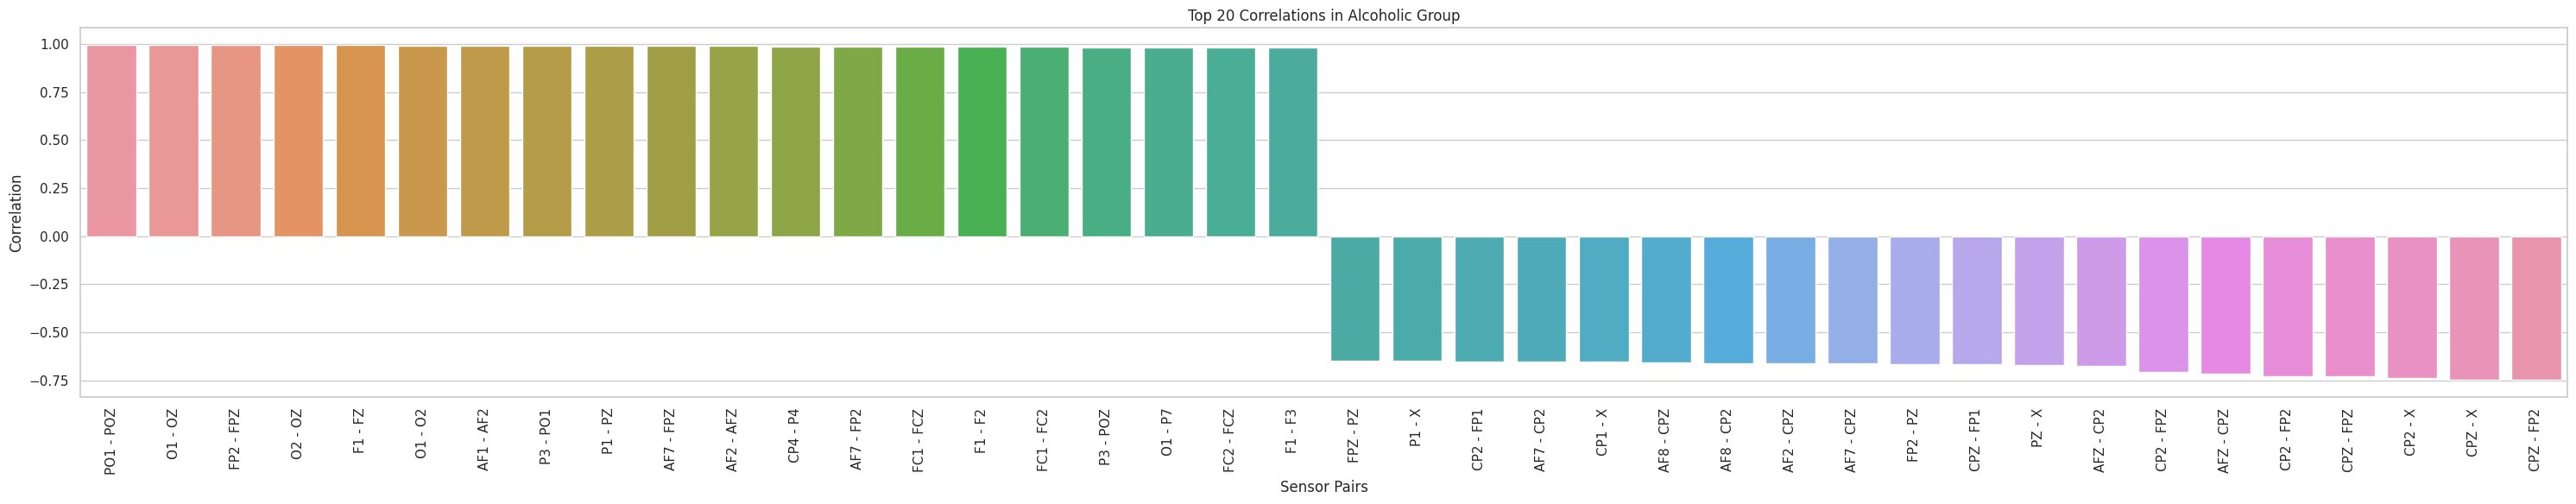

In [ ]:
print_top_n_correlations(train_df, identifier='a', n=20)

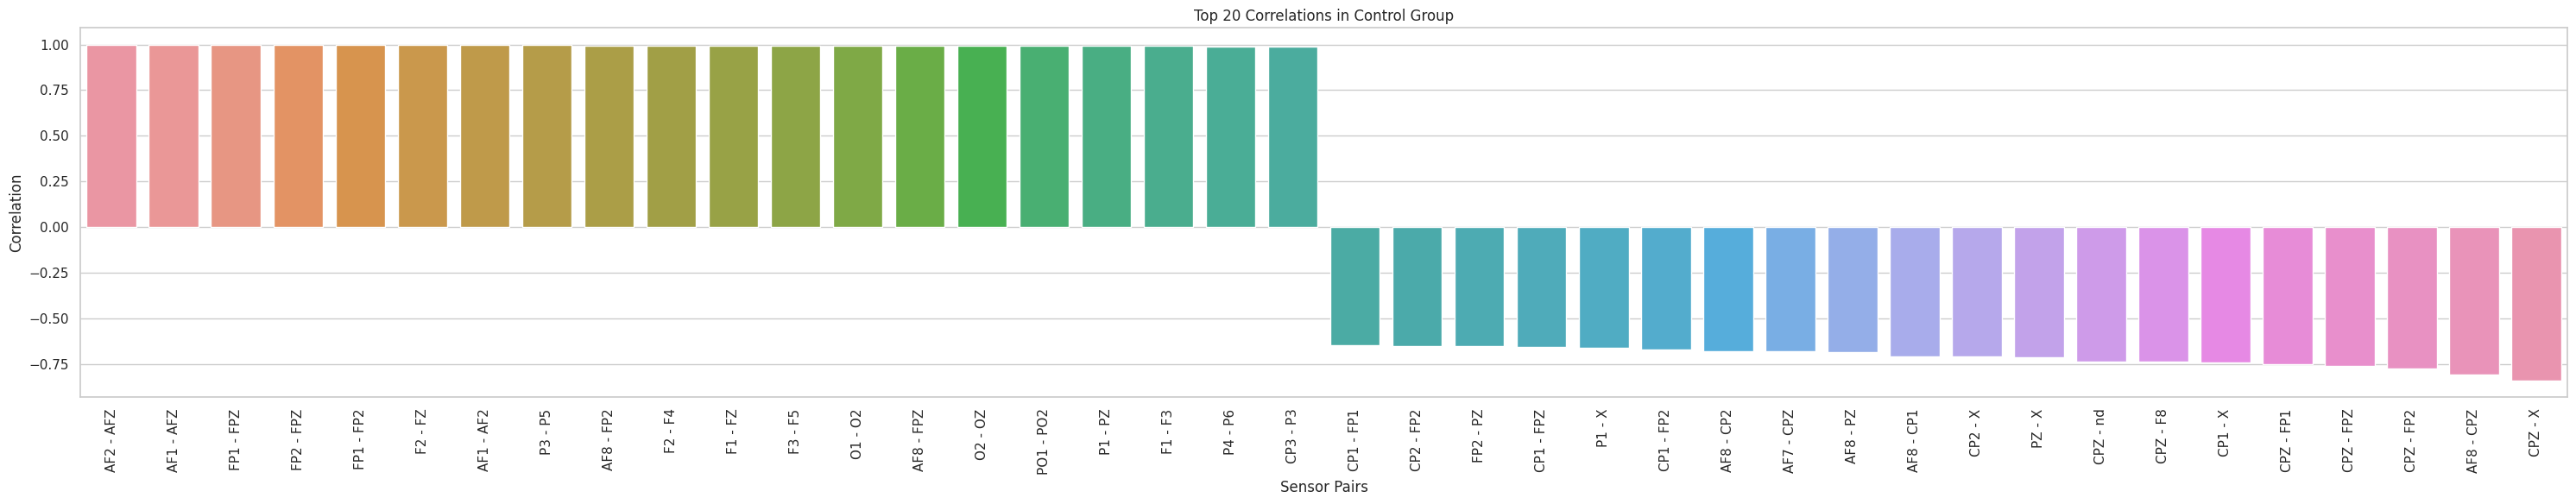

In [ ]:
print_top_n_correlations(train_df, identifier='c', n=20)

## Train and Evaluate Classifier

### Clinical use
This function is essential for training and evaluating a classifier using EEG sensor data to predict if the subject is alcoholic or not. It preprocesses the data, performs dimensionality reduction, trains a Support Vector Machine (SVM) classifier, evaluates its performance, and provides insights into feature importance (if applicable). By utilizing machine learning techniques, it aids in discerning patterns within EEG data and contributes to identifying significant features for subject identification in different matching conditions.

### Parameters
- `df`: The input DataFrame containing EEG sensor data.
- `selected_features` (optional): A list of specific features to be used for training the classifier. If not provided, all sensor data is used.
- `matching_conditions` (optional): A list of matching conditions to filter the dataset. If specified, the function processes data only for these matching conditions.

### Function Description

1. **Filter Data by Matching Conditions:**
   - Optionally filters the input DataFrame based on specified matching conditions.

2. **Data Transformation and Feature Selection:**
   - Transforms the DataFrame to a pivot table format for processing.
   - Selects specific features for training if `selected_features` is provided; otherwise, all sensor data is selected.

3. **Data Standardization and Dimensionality Reduction:**
   - Standardizes the selected features to have zero mean and unit variance.
   - Applies Principal Component Analysis (PCA) for dimensionality reduction while retaining 95% of the variance.

4. **Data Splitting and Classifier Training:**
   - Splits the data into training and testing sets (80% training, 20% testing).
   - Initializes and trains a Support Vector Machine (SVM) classifier with a linear kernel.

5. **Predictions and Evaluation:**
   - Makes predictions on the test set and calculates the accuracy of the classifier.
   - Prints the accuracy score for evaluation.

6. **Feature Importance (if applicable):**
   - If the classifier has attribute 'coef_', indicating feature importance, it prints the top features contributing to the classification.
   - Features are ranked based on their importance score in descending order.



In [ ]:
def train_and_evaluate_classifier(df, selected_features=None, matching_conditions=None):
    target = 'subject identifier'

    # Pre-filter dataset based on matching conditions
    if matching_conditions:
        df = df[df['matching condition'].isin(matching_conditions)]

    # Transform the DataFrame
    result_df = df.pivot_table(index=['trial number', 'sample num', 'subject identifier', 'matching condition', 'name'],
                               columns='sensor position', values='sensor value', aggfunc='first').reset_index()

    # Select specific features if provided, otherwise use all features
    if selected_features:
        features = selected_features
    else:
        features = result_df.columns[5:]  # Select columns from the 6th position to the end

    # Split the data into features and target
    X = result_df[features]
    y = result_df[target]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_pca = pca.fit_transform(X_scaled)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Initialize and train the SVC classifier
    svc_classifier = SVC(kernel='linear', random_state=42)
    svc_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = svc_classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Print feature importance (if applicable for the classifier)
    if hasattr(svc_classifier, 'coef_'):
        feature_importance = svc_classifier.coef_[0]
        sorted_indices = feature_importance.argsort()[::-1]  # Sort indices in descending order of importance

        print("Feature Importance:")
        for index in sorted_indices:
            print(f'{features[index]}: {feature_importance[index]:.4f}')
    else:
        print("Feature importance not available for this classifier.")

    return accuracy

In [ ]:
matching_conditions = [ 'S2 match']
selected_features = None

accuracy = train_and_evaluate_classifier(train_df, selected_features=selected_features, matching_conditions=matching_conditions)

Accuracy: 63.44%
Feature Importance:
F5: 0.8130
F2: 0.6120
CP3: 0.3289
CP6: 0.2831
F3: 0.2732
C1: 0.2371
CZ: 0.1619
AFZ: 0.1512
AF1: 0.0006
F4: -0.0194
AF2: -0.0231
AF8: -0.0338
AF7: -0.0571
C2: -0.1824
C6: -0.1840
C3: -0.2666
C4: -0.3200
CPZ: -0.3203
F1: -0.3432
CP1: -0.3681
CP4: -0.3835
CP2: -0.3981
C5: -0.4629
CP5: -0.5781


In [ ]:
matching_conditions = [ 'S1 obj']
selected_features = None

accuracy = train_and_evaluate_classifier(train_df, selected_features=selected_features, matching_conditions=matching_conditions)

Accuracy: 62.87%
Feature Importance:
C3: 0.4434
C5: 0.2502
CP5: 0.1940
C1: 0.1612
CP1: 0.1284
F4: 0.1223
AF8: 0.0458
C4: 0.0295
AF1: 0.0050
C6: -0.0423
F1: -0.0810
AF2: -0.1068
CP2: -0.1101
CPZ: -0.1183
AF7: -0.1215
C2: -0.1530
CP6: -0.2109
AFZ: -0.2236
F3: -0.2575
CP3: -0.3386
F2: -0.4193
CZ: -0.4565
F5: -0.4622
CP4: -0.6741


In [ ]:
matching_conditions = [ 'S2 nomatch,']
selected_features = None

accuracy = train_and_evaluate_classifier(train_df, selected_features=selected_features, matching_conditions=matching_conditions)

Accuracy: 64.69%
Feature Importance:
C4: 0.7192
CP5: 0.5276
F1: 0.4628
F2: 0.4515
C5: 0.3881
CZ: 0.3087
CP6: 0.2863
C6: 0.1804
C1: 0.1136
AFZ: 0.0913
CP4: 0.0826
C3: 0.0820
AF7: 0.0311
AF2: -0.0174
AF1: -0.0331
F3: -0.0616
CP2: -0.1238
AF8: -0.1464
CPZ: -0.2087
C2: -0.2484
CP1: -0.3124
CP3: -0.4327
F4: -0.5520
